# Convoluted Neural Network to Detect Cancer in Pathologic Scans

Link to Github Repository: https://github.com/CJTAYL/DTSA_5511_CNN_Project

## Libraries and Importing Data from Kaggle

In [3]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'histopathologic-cancer-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F11848%2F862157%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240212%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240212T195544Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1fb8ec8038f143f75f6d670232975815a8c3973afdb6ccbad07f85dc4088812266fd88b97c208ae6015d0a0d5c81031ca576c490179a499fbdde406fd7bcc51da8e06f177f8e9f135ea961ff90ef10865d02e5cf8399ee9dbd184b0fd1e10ef373df223a6250a77b9be8b6ea3a4fd57a392c0e611fd05e3a98a85f035d4b18afc4c905337ab450353f1412977f98ab45b05d2cc59ac3b6a44ede7b4fbb839ee8fbb868e681381bbc2aec525db51a408ec8a5cd2b5b38f6cefc0de18b4a19038357d978eba1690bb95132845243d5a890a9dccba0c342afabb5a3684281cd680a21198760732da6339c433e6eb3b8e7538855bc4dea5ffc17d8b3004e0e531f83'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 6773228425 bytes downloaded
Downloaded and uncompressed: histopathologic-cancer-detection
Data source import complete.


In [4]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from PIL import Image
import os
import shutil

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.layers import BatchNormalization, Conv2D, Flatten, Dense, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm_notebook,trange
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.metrics import AUC
from tensorflow.keras.applications import InceptionV3, DenseNet121, NASNetMobile

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import warnings
warnings.filterwarnings('ignore')


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Create a folder in the root directory
!mkdir -p "/content/drive/My Drive/CNN_Models"

# Summary of Problem

The timing of medical intervention is a critical determinant of patient outcomes. The earlier a disease is treated, the greater the likelihood of a successful outcome. However, various factors can delay the onset of treatment, such as patient awareness and education, the severity of symptoms, and a healthcare system's capacity and efficiency.

Advancements in technology offer promising solutions to enhance healthcare delivery. For instance, by automating certain diagnostic tasks, healthcare providers can redirect their attention to overcoming other obstacles that delay treatment, such as ensuring patients receive comprehensive and understandable information about their conditions and the available treatment options.

Machine learning, and deep learning in particular, is uniquely positioned to address these challenges. The purpose of this project is to showcase the proficiency of deep learning algorithms in analyzing pathological scans for signs of metastatic cancer.

# Description of Data and Preparation

The data used in the project were a modified version of the PatchCamelyon (PCam) benchmark dataset. The primary difference between the modified and original dataset is the number of duplicate images (the modified dataset has 0 duplicated images).

In [ ]:
base_dir = '../input/histopathologic-cancer-detection'
label_path = os.path.join(base_dir, 'train_labels.csv')
train_path = os.path.join(base_dir, 'train')
test_path = os.path.join(base_dir, 'test')
sample_path = os.path.join(base_dir, 'sample_submission.csv')

In [ ]:
# Check samples in training and testing datasets
print(f'Training Dataset Samples: {len(os.listdir(train_path))}')
print(f'Testing Dataset Samples: {len(os.listdir(test_path))}')

Training Dataset Samples: 220025
Testing Dataset Samples: 57458


In [ ]:
# Create dataframe to combine image id and labels from training dataset
df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))}) # load the filenames

# Load files names
df['id'] = df.path.map(lambda x: x.split('/')[4].split(".")[0]) # get image id to merge with training labels

train_labels = pd.read_csv(label_path)

# Merge training images and id
df = df.merge(train_labels, on = "id") # merge labels and filepaths

# Print preview of the dataframe
df.head()

,path,id,label
0,../input/histopathologic-cancer-detection/trai...,46105024ff3a3e27573a5e2bd09c203fe13b8c01,0
1,../input/histopathologic-cancer-detection/trai...,06e453e4a884641503342bfe95a01c888dd321e4,0
2,../input/histopathologic-cancer-detection/trai...,b298ce340245eecda51948c078e89dfec1f3d525,0
3,../input/histopathologic-cancer-detection/trai...,6c1dba614bf9b3c19872fb3bd2a4fb961419cc1e,1
4,../input/histopathologic-cancer-detection/trai...,baec85bf0392ebc76bb72ff50df23c1b4bfc7dca,1


In [ ]:
test_df = pd.DataFrame({'path': glob(os.path.join(test_path,'*.tif'))})
test_df['id'] = test_df.path.map(lambda x: x.split('/')[4].split(".")[0]) # get image id to merge with training labels

test_df.head()

,path,id
0,../input/histopathologic-cancer-detection/test...,092e552afdc98a4b23bfb2b9dce79d43803adcb6
1,../input/histopathologic-cancer-detection/test...,bde7ac98336b5b7546e81ac21df6d55014623b08
2,../input/histopathologic-cancer-detection/test...,653e518c619c368c72cfdc67884d6ae95773b613
3,../input/histopathologic-cancer-detection/test...,20657a7876e1000b3ebc6a3198cdddf024608b7e
4,../input/histopathologic-cancer-detection/test...,34ccb868407f557940dd03636d584315995a8115


# Exploratory Data Analysis

In [ ]:
# Check number of rows and columns
print(f'Number of Rows: {df.shape[0]}')
print(f'Number of Columns: {df.shape[1]}')

Number of Rows: 220025
Number of Columns: 3


In [ ]:
# Check for missing values and duplicates
print(f'Number of Missing Values: {df.isnull().sum().sum()}')
print(f'Number of Duplicate Values: {df.duplicated().sum()}')

Number of Missing Values: 0
Number of Duplicate Values: 0


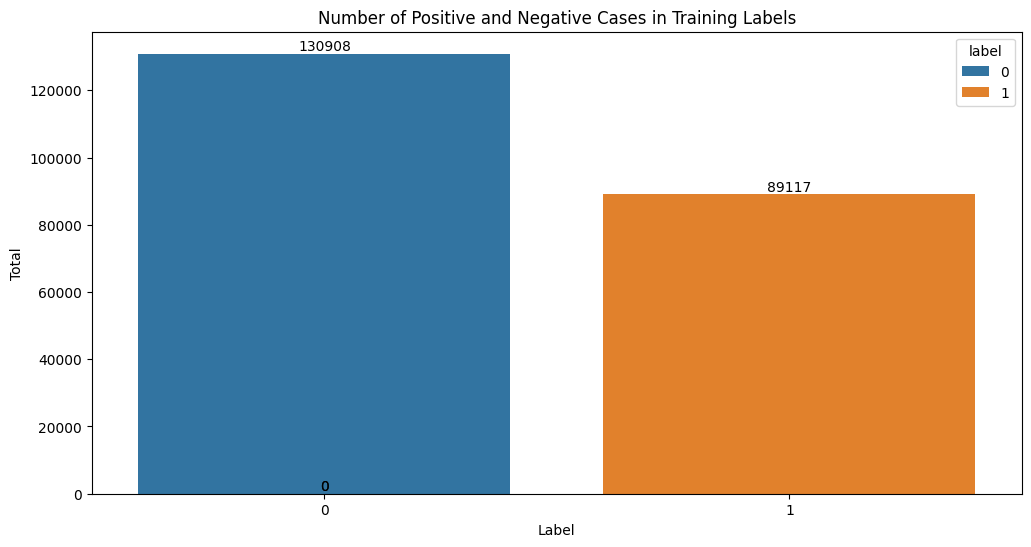

In [ ]:
# Plot of positive and negative classes in the training set
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='label', hue='label', data=train_labels)
plt.title('Number of Positive and Negative Cases in Training Labels')
plt.xlabel('Label')
plt.ylabel('Total')

# Add annotations
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points')

plt.show()

Based on the plot above, the dataset is imbalanced. Specifically, there are more negative cases than positive cases.

In [ ]:
def sample_portion_data(percentage, df):
    """
    Sample a percent of a DataFrame and return image pathname and labels
    percentage = decimal value indicating percentage of DataFrame to be extracted
    df = DataFrame with columns titled 'label' and 'path'
    """
    has_path = 'path' in df.columns
    has_label = 'label' in df.columns

    if has_path and has_label == True:
        # Select number of images from the DataFrame
        num_images = int(percentage * df.shape[0])
        # Select indices from DataFrame randomly
        ran_indices = np.random.choice(df.shape[0], size = num_images, replace=False)
        # Create numpy array for images
        images_array = np.zeros([num_images, 96, 96, 3], dtype=np.uint8)
        # Put labels in numpy array
        label_array = np.squeeze(df['label'].values)[ran_indices]
        # Read images using randomly selected indices
        for i, index in enumerate(ran_indices):
            images_array[i] = cv2.imread(df.loc[index, 'path'])

        return num_images, images_array, label_array

    else:
        return ("Reformat DataFrame to have columns that read 'label', and 'path'.")

In [ ]:
# Sample portion of data for EDA
n, X_sample, y_sample = sample_portion_data(0.05, df)

In [ ]:
# Review image size and pixel info
print(f'Image shape: {X_sample.shape}')
print(f'Image Maximum Pixel Value: {X_sample.max()}')
print(f'Image Minimum Pixel Value: {X_sample.min()}')

Image shape: (11001, 96, 96, 3)
Image Maximum Pixel Value: 255
Image Minimum Pixel Value: 0


In [ ]:
def convert_image(path):
    """
    Function to convert image from BGR colorspace to RGB colorspace
    """
    # Read image from path
    bgr_img = cv2.imread(path)
    # Split image into individual color channels
    b, g, r = cv2.split(bgr_img)
    # Merge separated channels into RGB image
    rgb_img = cv2.merge([r, g, b])
    return rgb_img

In [ ]:
def display_training_images(index, number_images):
    """
    Function to display a set number of images from the training dataset.
    index = index of images to display (e.g.,indices for negative images)
    number_images = the number of images to display - must be greater than or equal to 2
    """
    # Set area for plotting
    fig, ax = plt.subplots(1, number_images, figsize=(20, 5))
    # Extract images from range of indices
    for i, indx in enumerate(index):
        path = os.path.join(train_path, train_labels.iloc[indx]['id'])
        ax[i].imshow(convert_image(path + '.tif'))
    ax[0].set_ylabel('Samples', size='large')
    plt.show()

In [ ]:
# Selecting indices of negative images randomly
negative_indices = np.random.choice(train_labels[train_labels['label'] == 0].index, 5)

# Selecting indices of positive images randomly
positive_indices = np.random.choice(train_labels[train_labels['label'] == 1].index, 5)

## Sample of Negative Images

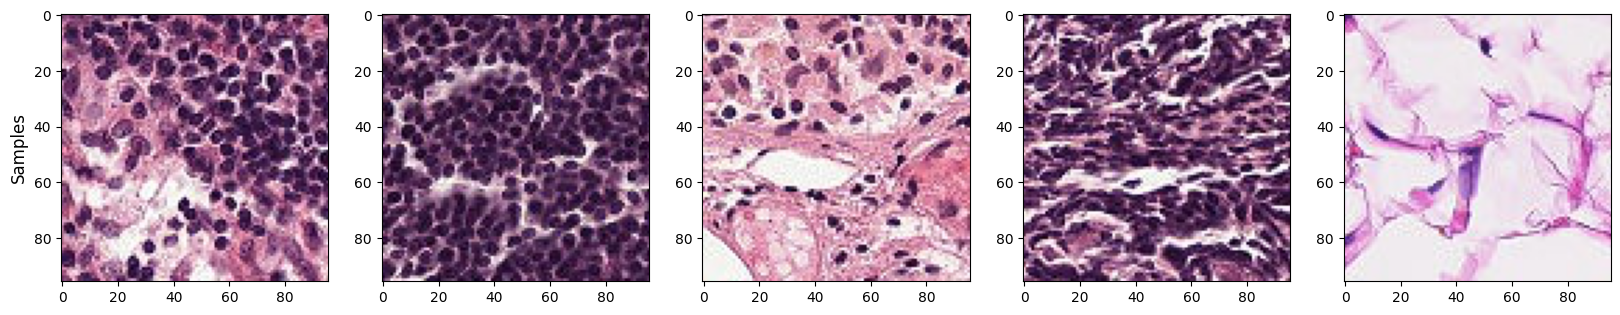

In [ ]:
display_training_images(negative_indices, 5)

## Sample of Positive Images

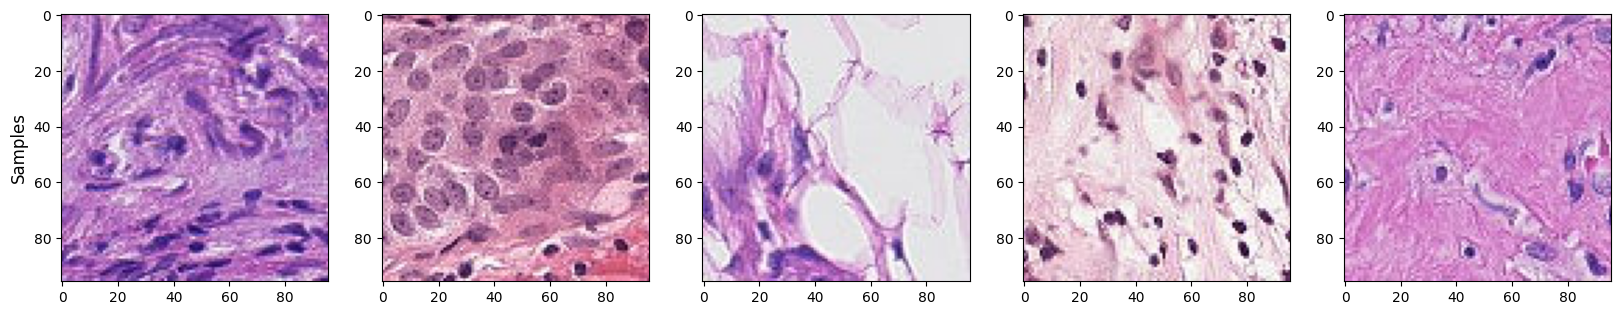

In [ ]:
display_training_images(positive_indices, 5)

In [ ]:
# Seperating positive and negative samples
positive_samples = X_sample[y_sample == 1]
negative_samples = X_sample[y_sample == 0]

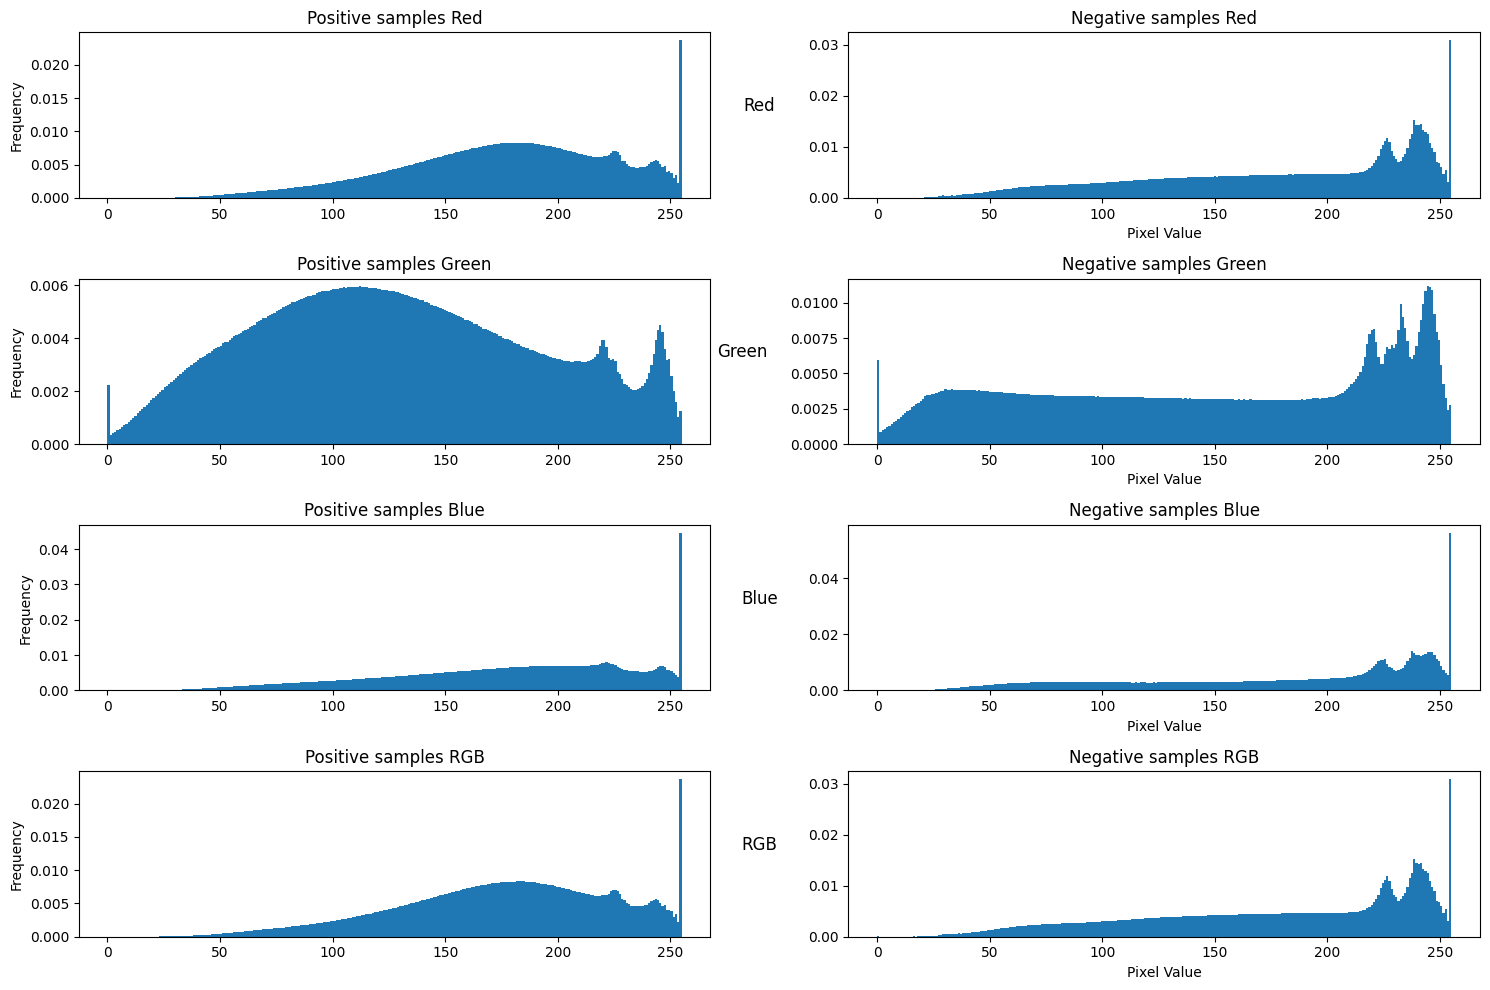

In [ ]:
# Histograms

bins = 256
channels = ['Red', 'Green', 'Blue', 'RGB']
types_of_samples = ['Positive', 'Negative']
samples = [positive_samples, negative_samples]

fig, axs = plt.subplots(4, 2, figsize=(15, 10))

for i, channel in enumerate(channels):
    for j, type_of_sample in enumerate(types_of_samples):
        current_samples = samples[j]

        axs[i, j].hist(current_samples[:, :, :, i % 3].flatten(), bins=bins, density=True)
        axs[i, j].set_title(f'{type_of_sample} samples {channel}')

        if j == 1:
            axs[i, j].set_ylabel(channel, rotation='horizontal', labelpad=35, fontsize=12)

for i in range(4):
    axs[i, 0].set_ylabel('Frequency')
    axs[i, 1].set_xlabel('Pixel Value')

fig.tight_layout()

plt.show()

## Segmentation of Dataset

In [ ]:
# Create training and validation datasets
df_train, df_val = train_test_split(df, test_size=0.10, random_state=24)

In [ ]:
df.set_index('id', inplace=True)

# Model Developement

In [ ]:
# Create directories for model augmentation
work_dir ='/kaggle/working/data'
train_dir = os.path.join(work_dir,'train')
val_dir = os.path.join(work_dir,'val')
test_dir = os.path.join(work_dir, 'test')

if os.path.exists(work_dir):
    shutil.rmtree(work_dir)

for fold in [test_dir]:
    os.makedirs(os.path.join(fold))

for fold in [train_dir, val_dir]:
    for subf in ["0", "1"]:
        os.makedirs(os.path.join(fold, subf))

In [ ]:
# Copy all files to train and validation directies

# Copy train files
for id in df_train['id'].values:
    fn =id +'.tif'
    label = str(df.loc[id,'label'])
    source_dir_fn=os.path.join(train_path, fn)
    train_dir_fn=os.path.join(train_dir,label,fn)
    shutil.copyfile(source_dir_fn,train_dir_fn )

# Copy validation files
for id in df_val['id'].values:
    fn =id +'.tif'
    label = str(df.loc[id,'label'])
    source_dir_fn =os.path.join(train_path, fn)
    val_dir_fn =os.path.join(val_dir,label,fn)
    shutil.copyfile(source_dir_fn,val_dir_fn )

# Copy test files
for id in test_df['id'].values:
    fn = id + '.tif'
    source_dir_fn = os.path.join(test_path, fn)
    test_dir_fn = os.path.join(test_dir, fn)
    shutil.copyfile(source_dir_fn, test_dir_fn)

In [ ]:
# Prepare the submission dataframe to enter testing data into the model
submission_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')

submission_df['path'] = submission_df.id + '.tif'

## Model Architecture

The initial model was a convolutional neural network that used the InceptionV3 architecture as the base model for feature extraction. The model's weights were from the ImageNet dataset. The model included several layers including custom top layers based on the input data and a dropout layer to guard against overfitting. The learning rate schedule used exponential decay, which decreased the learning rate ( 𝛼 ) over time during training. The initial learning rate was set to 0.001, the decay steps = 1000, and the decay rate = 0.9. Finally, the model was compiled using the stochastic gradient descent optimizer. To increase stability and the speed of the optimizer, momentum ( 𝛾 ) was set at 0.9. The model was evaluated using Area Under the Curve (AUC).

The InceptionV3 architecture was chosen due to its popularity for working with image recognition and classification tasks. It was trained on a large dataset (i.e., ImageNet), which means it has been exposed to variety of visual structures and complex patterns. Additionally, the InceptionV3 architecture includes regularization methods, like label-smoothing, which can help prevent overfitting on training data. The values for the learning rate, decay steps, and decay rate were chosen due to their frequent use in deep learning models.

After training, the model had the following parameters:
- Total parameters: 22065185
- Trainable parameters: 262401
- Non-trainable parameters: 21808784

In [ ]:
base_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

for layers in base_inception.layers:
    layers.trainable = False

x = base_inception.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

initial_learning_rate = 0.001
decay_steps = 1000
decay_rate = 0.9
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps, decay_rate, staircase=True)

model1 = Model(inputs=base_inception.input, outputs=predictions)

model1.compile(optimizer=SGD(learning_rate = lr_schedule, momentum = 0.9),
              loss='binary_crossentropy',
              metrics=[AUC()])

model1.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 47, 47, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 47, 47, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

# Assuming you have `train_dir` and `val_dir` directories structured properly
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary')

test_generator = test_datagen.flow_from_dataframe(
    dataframe = submission_df,
    directory = test_path,
    x_col = 'path',
    batch_size = 32,
    shuffle = False,
    class_mode = None,
    target_size = (96, 96)
    )

# Verify that train_generator and validation_generator are set up correctly
print(f"Found {train_generator.samples} images for training.")
print(f"Found {validation_generator.samples} images for validation.")
print(f"Found {test_generator.samples} images for testing.")

Found 198022 images belonging to 2 classes.
Found 22003 images belonging to 2 classes.
Found 57458 validated image filenames.
Found 198022 images for training.
Found 22003 images for validation.
Found 57458 images for testing.


## Model Training

In [ ]:
# Define the callbacks
callbacks_list = [
    ModelCheckpoint(
        filepath='best_model.h5',
        monitor='val_loss',
        save_best_only=True
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
]

# Train the model with try-except to catch any errors during training
try:
    history = model1.fit(
        train_generator,
        steps_per_epoch=max(1, train_generator.samples // train_generator.batch_size),
        epochs=5,
        validation_data=validation_generator,
        validation_steps=max(1, validation_generator.samples // validation_generator.batch_size),
        callbacks=callbacks_list
    )
except ValueError as e:
    print("Caught a ValueError during training:", e)

Epoch 1/5
6188/6188 [==============================] - 894s 145ms/step - loss: 0.4701 - auc: 0.8492 - val_loss: 0.4230 - val_auc: 0.8829
Epoch 2/5
6188/6188 [==============================] - 858s 139ms/step - loss: 0.4510 - auc: 0.8627 - val_loss: 0.4165 - val_auc: 0.8886
Epoch 3/5
6188/6188 [==============================] - 851s 137ms/step - loss: 0.4453 - auc: 0.8670 - val_loss: 0.4137 - val_auc: 0.8894
Epoch 4/5
6188/6188 [==============================] - 858s 139ms/step - loss: 0.4434 - auc: 0.8674 - val_loss: 0.4092 - val_auc: 0.8911
Epoch 5/5
6188/6188 [==============================] - 849s 137ms/step - loss: 0.4421 - auc: 0.8683 - val_loss: 0.4104 - val_auc: 0.8909


In [ ]:
folder_path = '/content/drive/MyDrive/CNN_Models'

# Save model
model1.save(folder_path)

## Evaluation of Training Process

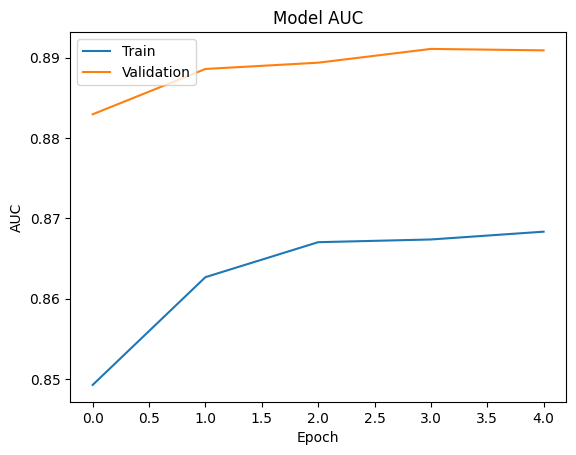

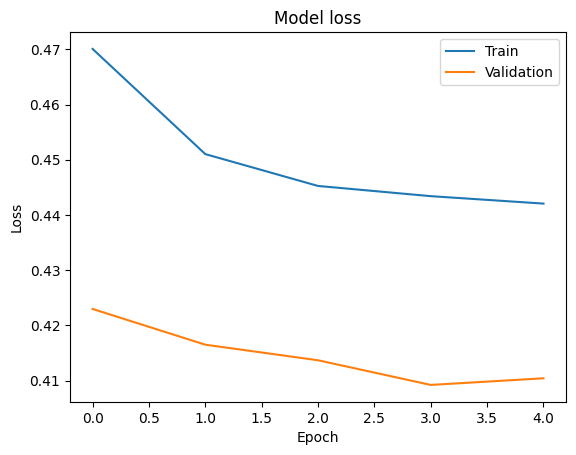

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Predictions on Test Dataset

In [ ]:
# Make prediction based on the testing dataset
predictions = model1.predict(test_generator)
predicted_classes = predictions > 0.5 # Apply threshold
predicted_classes = predicted_classes.astype(int)

1796/1796 [==============================] - 101s 54ms/step


In [ ]:
# Replace label column with predicted classes
submission_df['label'] = predicted_classes

# Creating new dataframe to convert into CSV file
submission_dframe = submission_df.drop('path', axis = 1)

In [ ]:
file_name = 'submission1.csv'
full_path = f'{folder_path}/{file_name}'

# Save the DataFrame as a CSV file
submission_dframe.to_csv(full_path, header=True, index=False)


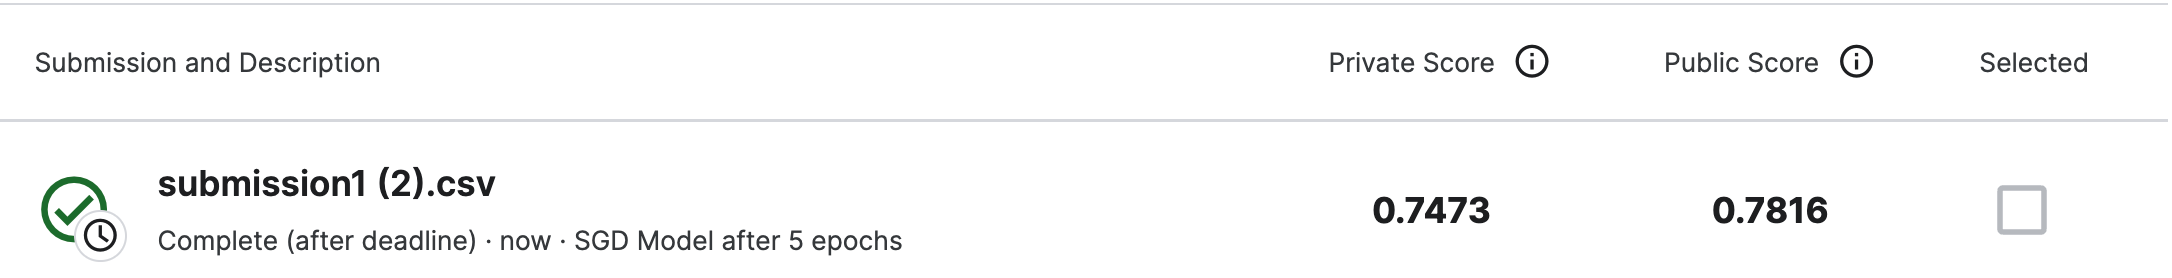

# Hyperparameter Fine Tuning

In an attempt to improve the performance of the model, some of the hyperparameters were fine tuned. The first 15 layers of the model were unfrozen and re-trained using a modified learning rate, which was calculated with the following formula:

$$ \alpha_1 * 0.01 $$

where $\alpha_1$ represents the initial learning. The other hyperparameters were left unchanged to isolate the effects of modifying the learning rate.

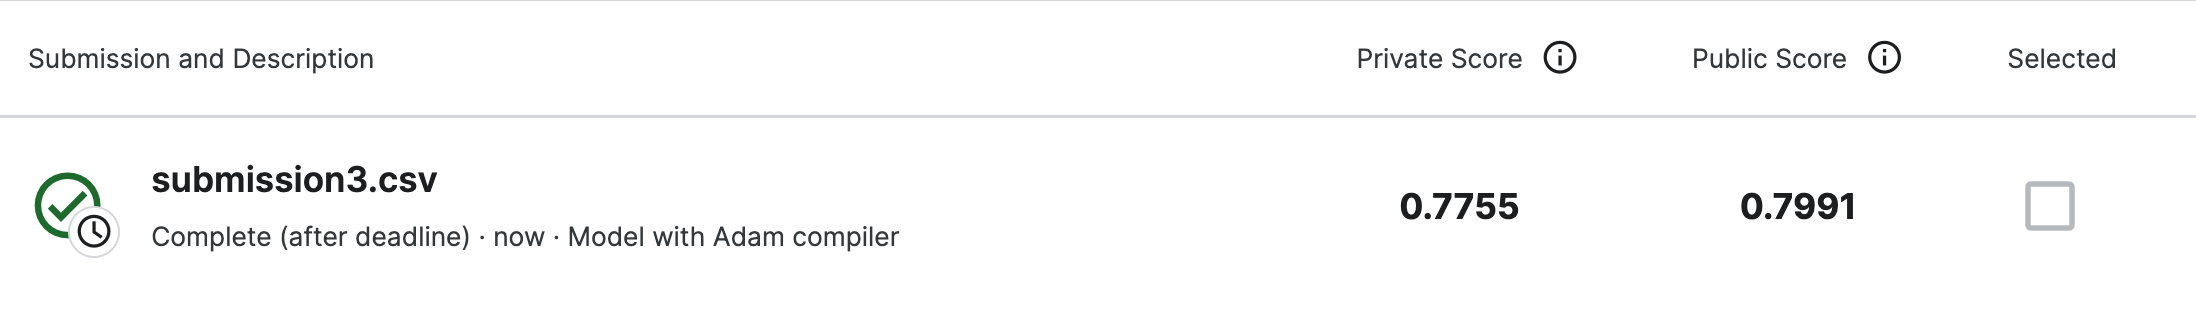After training, the updated model had the following parameters:
- Total parameters: 22065185
- Trainable parameters: 657281
- Non-trainable parameters: 21407904

In [ ]:
# Unfreeze layers of model
for layer in base_inception.layers:
    layer.trainable = False

# N = number of layers to unfreeze
N = 15
for layer in base_inception.layers[-N: ]:
    layer.trainable = True

# Update learning rate
fine_tuning_learning_rate = initial_learning_rate * 0.1
lr_schedule = ExponentialDecay(fine_tuning_learning_rate, decay_steps, decay_rate, staircase=True)

model1.compile(optimizer=SGD(learning_rate = lr_schedule, momentum = 0.9),
              loss='binary_crossentropy',
              metrics=[AUC()])

model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 47, 47, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 47, 47, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 47, 47, 32)           0         ['batch_normalization[0][0

## Training the Updated Model

In [ ]:
# Define the callbacks
callbacks_list = [
    ModelCheckpoint(
        filepath='best_model.h5',
        monitor='val_loss',
        save_best_only=True
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
]

# Train the model with try-except to catch any errors during training
try:
    history = model1.fit(
        train_generator,
        steps_per_epoch=max(1, train_generator.samples // train_generator.batch_size),
        epochs=4,
        validation_data=validation_generator,
        validation_steps=max(1, validation_generator.samples // validation_generator.batch_size),
        callbacks=callbacks_list
    )
except ValueError as e:
    print("Caught a ValueError during training:", e)

Epoch 1/4
6188/6188 [==============================] - 982s 158ms/step - loss: 0.4670 - auc_1: 0.8516 - val_loss: 0.4211 - val_auc_1: 0.8863
Epoch 2/4
6188/6188 [==============================] - 970s 157ms/step - loss: 0.4518 - auc_1: 0.8613 - val_loss: 0.4133 - val_auc_1: 0.8896
Epoch 3/4
6188/6188 [==============================] - 894s 144ms/step - loss: 0.4499 - auc_1: 0.8625 - val_loss: 0.4115 - val_auc_1: 0.8907
Epoch 4/4
6188/6188 [==============================] - 931s 150ms/step - loss: 0.4488 - auc_1: 0.8635 - val_loss: 0.4097 - val_auc_1: 0.8914


## Evaluation of the Training Process

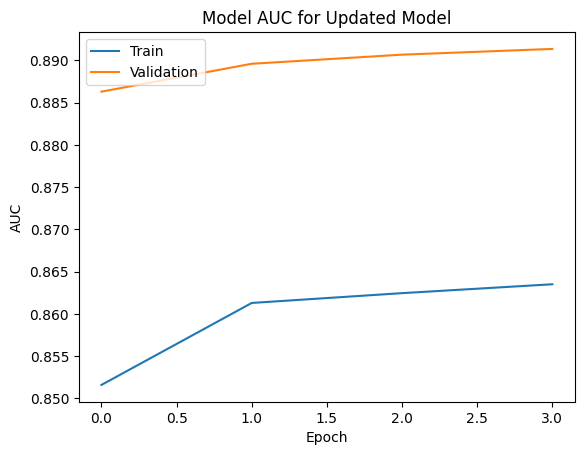

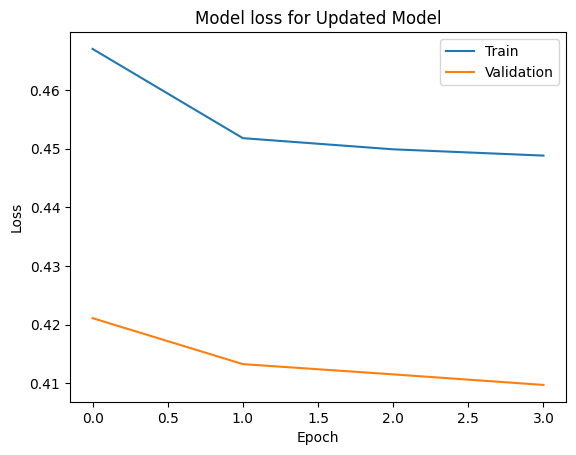

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['auc_1'])
plt.plot(history.history['val_auc_1'])
plt.title('Model AUC for Updated Model')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss for Updated Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Make predictions using the updated model and the testing dataset
predictions = model1.predict(test_generator)
predicted_classes = predictions > 0.5 # Apply threshold
predicted_classes = predicted_classes.astype(int)

1796/1796 [==============================] - 97s 53ms/step


In [ ]:
# Replace label column with predicted classes
submission_df['label'] = predicted_classes

# Creating new dataframe to convert into CSV file
submission_dframe = submission_df.drop('path', axis = 1)

In [ ]:
file_name = 'submission2.csv'
full_path = f'{folder_path}/{file_name}'

# Save the DataFrame as a CSV file
submission_dframe.to_csv(full_path, header=True, index=False)

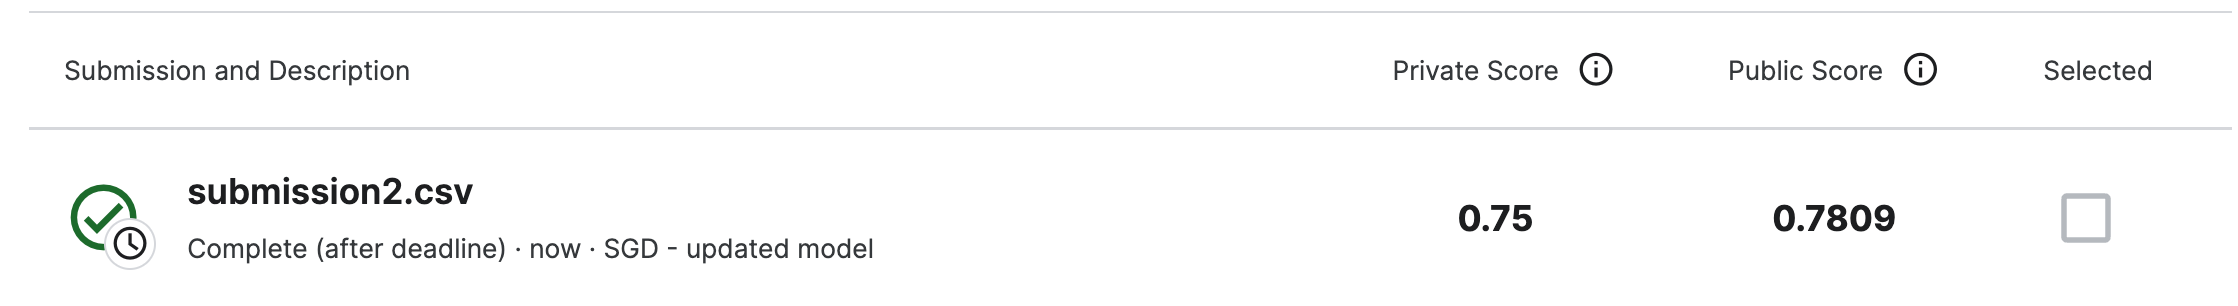

The initial model performed moderately well. Specicifically, during the last epoch of training, the AUC was 0.8683 and 0.8909 for the training and validation sets, respectively. When the test dataset was inputted into the model the private and public scores were 0.7473 and 0.7816, respectively.

The updated model also performed moderately well. Specifically, during the last epoch of training, the AUC was 0.8635 and 0.8914 for the training and validation sets, respectively. When the test dataset was inputted into the updated model, teh private and public scores were 0.75 and 0.7809, respectively.

When comparing the scores of the two models, there doesn't appear to be meaningful difference between the two, indicating that the change to the learning rate had little effect on the model's performance.

## Adam Optimizer

Based on the similarity of the two initial models, a third model using the Adam optimizer was compiled. Other than the type of compiler, the hyperparameters were unchanged from the second model using the SGD compiler.

The Adam compiler was selected due to its:
- adaptive learning rates
- convergence speed
- suitability for large datasets and high dimensional spaces
- balance of momentum and velocity

After training, the model with the Adam compiler had the following parameters:
- Total parameters: 22065185
- Trainable parameters: 657281
- Non-trainable parameters: 21407904

In [ ]:
# Unfreeze layers of model
for layer in base_inception.layers:
    layer.trainable = False

# N = number of layers to unfreeze
N = 15
for layer in base_inception.layers[-N: ]:
    layer.trainable = True

# Update learning rate
fine_tuning_learning_rate = initial_learning_rate * 0.1
lr_schedule = ExponentialDecay(fine_tuning_learning_rate, decay_steps, decay_rate, staircase=True)

model1.compile(optimizer=Adam(learning_rate = lr_schedule),
              loss='binary_crossentropy',
              metrics=[AUC()])

model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 47, 47, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 47, 47, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 47, 47, 32)           0         ['batch_normalization[0][0

In [ ]:
# Define the callbacks
callbacks_list = [
    ModelCheckpoint(
        filepath='best_model.h5',
        monitor='val_loss',
        save_best_only=True
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
]

# Train the model with try-except to catch any errors during training
try:
    history = model1.fit(
        train_generator,
        steps_per_epoch=max(1, train_generator.samples // train_generator.batch_size),
        epochs=4,
        validation_data=validation_generator,
        validation_steps=max(1, validation_generator.samples // validation_generator.batch_size),
        callbacks=callbacks_list
    )
except ValueError as e:
    print("Caught a ValueError during training:", e)

Epoch 1/4
6188/6188 [==============================] - 942s 151ms/step - loss: 0.4259 - auc_2: 0.8783 - val_loss: 0.3675 - val_auc_2: 0.9125
Epoch 2/4
6188/6188 [==============================] - 885s 143ms/step - loss: 0.4061 - auc_2: 0.8898 - val_loss: 0.3577 - val_auc_2: 0.9162
Epoch 3/4
6188/6188 [==============================] - 874s 141ms/step - loss: 0.3984 - auc_2: 0.8944 - val_loss: 0.3540 - val_auc_2: 0.9188
Epoch 4/4
6188/6188 [==============================] - 871s 141ms/step - loss: 0.3957 - auc_2: 0.8960 - val_loss: 0.3507 - val_auc_2: 0.9200


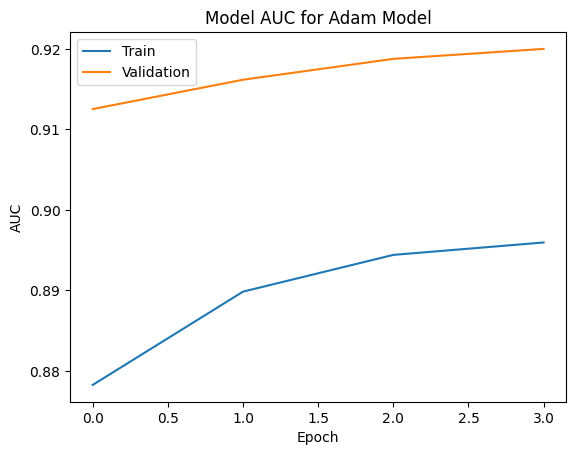

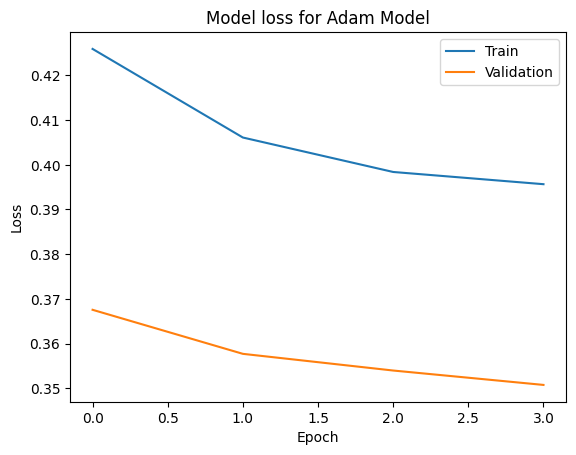

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['auc_2'])
plt.plot(history.history['val_auc_2'])
plt.title('Model AUC for Adam Model')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss for Adam Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Make predictions using the updated model and the testing dataset
predictions = model1.predict(test_generator)
predicted_classes = predictions > 0.5 # Apply threshold
predicted_classes = predicted_classes.astype(int)

1796/1796 [==============================] - 98s 54ms/step


In [ ]:
# Replace label column with predicted classes
submission_df['label'] = predicted_classes

# Creating new dataframe to convert into CSV file
submission_dframe = submission_df.drop('path', axis = 1)

In [ ]:
file_name = 'submission3.csv'
full_path = f'{folder_path}/{file_name}'

# Save the DataFrame as a CSV file
submission_dframe.to_csv(full_path, header=True, index=False)

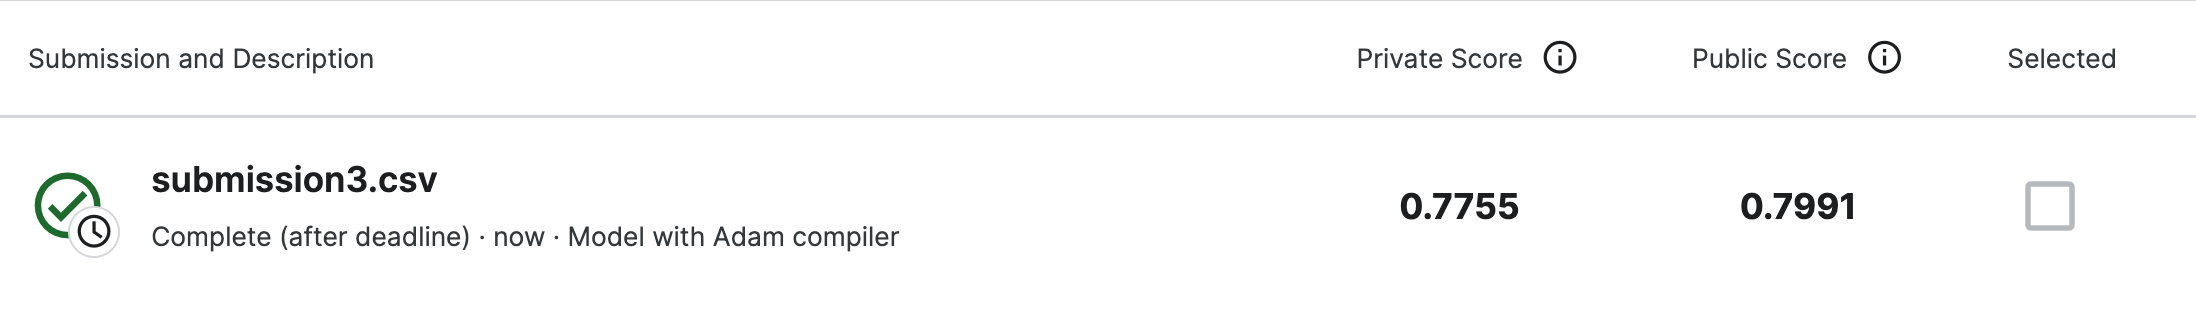

The results of the model built with the Adam compiler were slightly better than the two models built with SGD. During the final training epoch the AUC scores were 0.8960 and 0.9200 for the training and validation sets, respectively. When the testing dataset was inputted into the model, the private and public scores were 0.7755 and 0.7991, respectively.

## Results and Conclusion

In [8]:
results_df = pd.DataFrame({
    'Model':['Model 1', 'Model 2', 'Model 3'],
    'Optimizer': ['SGD', 'SGD', 'Adam'],
    'Initial LR': [0.001, 0.0001, 0.0001],
    'Private Score': [0.7473, 0.75, 0.7755],
    'Public Score': [0.7816, 0.7809, 0.7991]
})

results_df

,Model,Optimizer,Initial LR,Private Score,Public Score
0,Model 1,SGD,0.0010,0.7473,0.7816
1,Model 2,SGD,0.0001,0.7500,0.7809
2,Model 3,Adam,0.0001,0.7755,0.7991


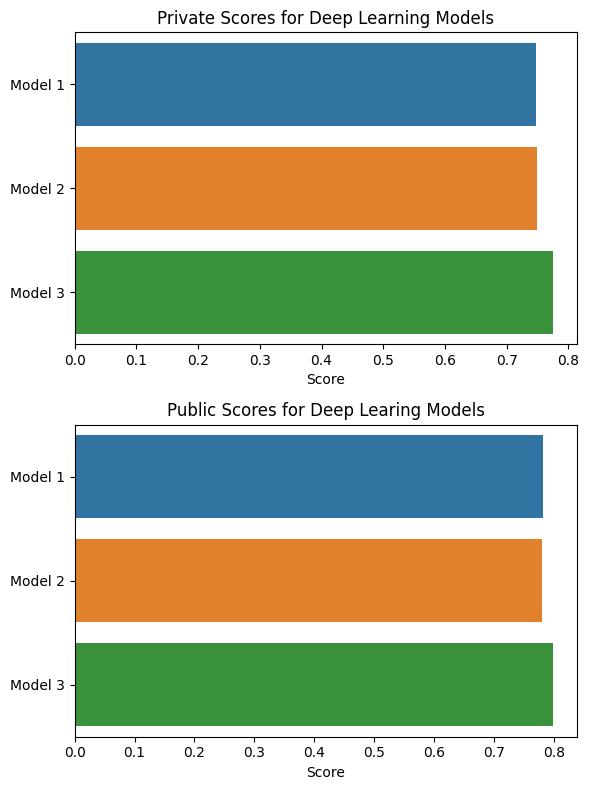

In [18]:
plt.figure(figsize=(6, 8))

plt.subplot(2, 1, 1)
sns.barplot(data=results_df, y='Model', x='Private Score', hue='Model')
plt.ylabel('')
plt.xlabel('Score')
plt.title('Private Scores for Deep Learning Models')

plt.subplot(2, 1, 2)
sns.barplot(data=results_df, y='Model', x='Public Score', hue='Model')
plt.ylabel('')
plt.xlabel('Score')
plt.title('Public Scores for Deep Learing Models')

plt.tight_layout()

plt.show()

Three classification models were built to demonstrate how deep learning algorithms can be leveraged as diagnostic tools for medical professional responsible for diagnosing diseases.

Ultimately, none of the models performed well enough to be used in a clinical setting; however, their performance demonstrates the potential of deep learning technology.

Of the three models, the model compiled with the Adam optimizer performed the best with private and public scores of 0.7755 and 0.7991, respectively. However, it is important to note that there did not appear to be a significant difference between the models (see plots above).

Some potential reasons as to why the model built with the Adam optimizer was the best performing model include the way it adapts the learning rate during training, its use of first-order gradients, and its robustness to the choice of hyperparameters.

# References

Adam: A Method for Stochastic Optimization
- Authors: Diederik P. Kingma, Jimmy Ba
- Published: 2014
- Link: https://arxiv.org/abs/1412.6980

CNN Cancer Detection - InceptionTransferLearning (Kaggle Notebook)
- Author: Jieshends2020
- Published: 2024
- Link: https://www.kaggle.com/code/jieshends2020/cnn-cancer-detection-inceptiontransferlearning

Deep Learning
-Authors: Ian Goodfellow, Yoshua Bengio, Aaron Courville
- Link: http://www.deeplearningbook.org/

Load and Preprocess Images
- Link: https://www.tensorflow.org/tutorials/load_data/images

On the Convergence of Adam and Beyond
- Authors: Sashank J. Reddi, Satyen Kale, Sanjiv Kumar
- Published: 2018
- Link: https://arxiv.org/abs/1904.09237

SB_HCD_KT_Sub (Kaggle Notebook)
- Authors: Sara Bronson, Jeffery Boczkaja, Shay J
- Published 2023
- Link: https://www.kaggle.com/code/sarabronson/sb-hcd-kt-sub